# Задание

На нашем сайте есть открытая информация, касающаяся машин на линии, зон работы сервиса итд
Она лежит тут: http://youdrive.today/info

1. Что можно сказать про наш автопарк? Какие самые частые машины в разных городах/зонах? 

2. Какое распределение имеют машины по уровню топлива?

3. Насколько часто используется режим "Передача" (это специальный режим, когда пользователь может оставить машину вне зоны завершения аренды и платить небольшую стоимость за то время, пока машину не заберет кто-то другой: https://youdrive.today/rates)? Может имеет смысл расширять нашу зону в места, где часто оставляют машины с помощью этой функции? Как вообще можно принимать решение о том, как менять наши зоны работы?

4. Представьте, что вы работаете в конкурирующей компании. Какие наши операционные данные можно оценить по этим данным? Как это сделать? 

# Загрузка данных разведовательный анализ и предобработка датасета

Подгружаем библиотеки, которые будем использовать в анализе.

In [1]:
import pandas as pd
import requests 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

Загрузим данные с сайта, преобразуем их в словарь, посмотрим, какие данные опубликованы на сайте.

In [2]:
raw_data = requests.get('http://youdrive.today/info').json()
print(raw_data.keys())

dict_keys(['cars', 'area', 'areas', 'area_groups', 'layers', 'success'])


Полученные данные содержат сведения о шести объектах. Проведём разведовательный анализ данных для каждого объекта.

### Cars

In [69]:
cars = pd.DataFrame(raw_data['cars'])
display(cars.info())
display(cars.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      3407 non-null   float64
 1   longitude     3407 non-null   float64
 2   pin_img       3407 non-null   object 
 3   color         3407 non-null   object 
 4   model         3407 non-null   object 
 5   img           3407 non-null   object 
 6   transmission  3407 non-null   object 
 7   fuel          3407 non-null   int64  
 8   discount      3407 non-null   int64  
 9   is_parther    3407 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 243.0+ KB


None

,latitude,longitude,pin_img,color,model,img,transmission,fuel,discount,is_parther
0,55.805028,37.818712,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,68,0,False
1,55.738604,37.691464,https://youdrive.today/static/resources/car_po...,black,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,73,0,False
2,59.860764,30.477592,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,83,0,False
3,55.676352,37.428352,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,78,0,False
4,59.945636,30.241034,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,58,0,False


Датасет cars содержит сведения об автомобилях: координаты местоположения, изображения автомобиля, цвет, модель, сведения о запасе топлива, какой-то дисконт, и признак is_partner. 

Проанализируем эти признаки, написав для этого функцию.

In [4]:
for item in cars.columns:
    print(cars[item].dtype == 'object')

False
False
True
True
True
True
True
False
False
False


In [5]:
def eda(dataset, column, bins=10):

    column = dataset[column]

    display(column.describe())
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    if column.dtype == 'object' or column.dtype == 'bool':
        sns.countplot(x=column.name, data=dataset, color='b').set_title(
            column.name.upper(), fontdict={'fontsize': 16})
    else:
        sns.histplot(data=dataset, x=column.name, bins=bins, color='b').set_title(
            column.name.upper(), fontdict={'fontsize': 16})

count      3407
unique       11
top       white
freq       1762
Name: color, dtype: object

white        51.72
black        18.32
gray         12.68
silver        8.78
blue          3.79
dark gray     3.55
brown         0.59
orange        0.23
red           0.18
yellow        0.15
Белый         0.03
Name: color, dtype: float64

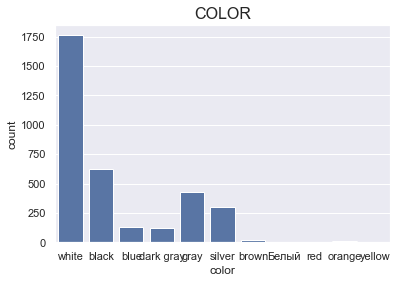

In [6]:
eda(cars, 'color')

Видим, что в датасете 2758 автомобилей. Более половины автомобилей имеют белый цвет. Также видим одну аномалию: в датасете присутствует описание цвета на русском языке, тогда как большинство признаков указано на английском. Исправим это, и проанализируем признак transmission.

In [7]:
cars.color = cars.color.replace('Белый','white')

count          3407
unique            2
top       automatic
freq           3406
Name: transmission, dtype: object

automatic    99.97
robot         0.03
Name: transmission, dtype: float64

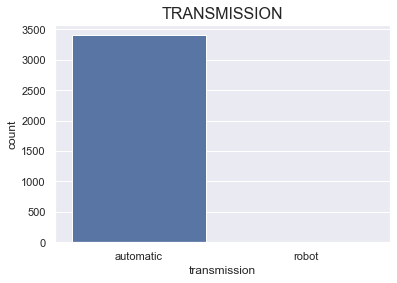

In [8]:
eda(cars, 'transmission')

Видим, что все автомобили за исключением одного имеют автоматическую трансмиссию. По видимому, данный признак нам не понадобится для дальнейшего анализа.

Проанализируем признак discount.

count    3407.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: discount, dtype: float64

0    100.0
Name: discount, dtype: float64

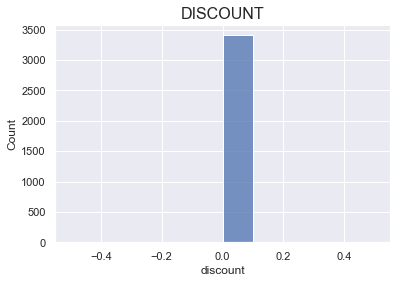

In [9]:
eda(cars, 'discount')

Непонятно, что это означает, но он у всех автомобилей равен нулю. Возможно, это скидки к действующим тарифам, которые могут быть применены для некоторых автомобилей.

Проанализируем признак is_parther.

count      3407
unique        1
top       False
freq       3407
Name: is_parther, dtype: object

False    100.0
Name: is_parther, dtype: float64

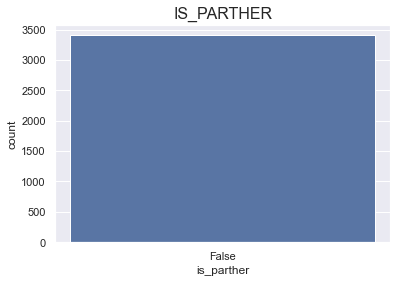

In [10]:
eda(cars, 'is_parther')

Везде значение 'ложь'. Предположительно, этот признак означает, что автомобиль принадлежит третьему лицу и находится в доверительном управлении у YouDrive. Вероятно, таких автомобилей сейчас нет.

Проанализируем признак fuel.

count    3407.000000
mean       69.148811
std        22.264370
min         8.000000
25%        54.000000
50%        72.000000
75%        88.000000
max       100.000000
Name: fuel, dtype: float64

100    11.71
90      3.93
83      3.20
77      2.79
60      2.76
       ...  
10      0.06
99      0.06
9       0.06
19      0.06
8       0.03
Name: fuel, Length: 92, dtype: float64

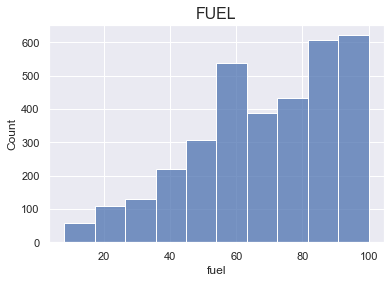

In [11]:
eda(cars, 'fuel')

Видно, что все значения признака fuel находятся в интервале от 0 до 100. Вероятно, этот признак обозначает запасы топлива в процентах.

Добавим в датасет ещё один признак: топливо, потреблённое после заправки.

count    3407.000000
mean       30.851189
std        22.264370
min         0.000000
25%        12.000000
50%        28.000000
75%        46.000000
max        92.000000
Name: fuel_cons, dtype: float64

0     11.71
10     3.93
17     3.20
23     2.79
43     2.76
      ...  
91     0.06
1      0.06
81     0.06
90     0.06
92     0.03
Name: fuel_cons, Length: 92, dtype: float64

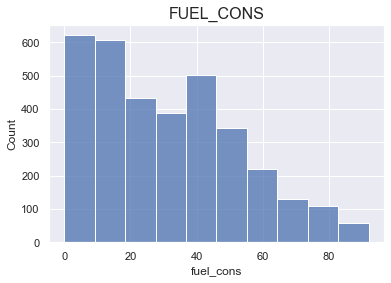

In [12]:
cars['fuel_cons'] = cars.fuel.apply(lambda x: 100-x)
eda(cars, 'fuel_cons')

Попытаемся выдвинуть гипотезу, какое распределение имеют машины по уровню топлива.

Предположим, что потребление топлива происходит с некоторой средней скоростью. В таком случае с некоторой средней частотой будут происходить события по заправке автомобилей топливом. В случае наступления указанного события уровень топлива повышается до 100%.

Нам не известно, с какой средней интенсивностью потребляется топливо, с какой частотой происходит заправка, и какое распределение имеют эти параметры.

Предположим, что уровень топлива оперделяется функцией: $$P = 100 - V \times T,$$

где $P$ - уровень топлива;
$V$ - скорость потребления топлива;
$T$ - время прошедшее с момента последней заправки. 

Предположим, что заправка происходит через интервалы времени $X$, после которой уровень топлива становится равным 100. В таком случае имеем уравнение: $$(100-P_п)= V\times X,$$

где $P_п$ - уровень при котором происходит заправка автомобиля.

Далее получим, что :$$P = 100 - (100-P_п) \frac {T}{X} $$.

Таким образом, получаем, что случайная величина Р - это функция трёх случайных величин.

Из статистики известно, что интервалы времени между независимыми событиями, происходящими со средней интенсивностью  $λ$ описываются экспоненциальным распределением. Таким образом, предположим, что $X$ имеет экспоненциальное распределение.

Нам не известны условия, при которых производится заправка автомобиля. Это может быть уровень топлива, например, менее 20%. Таким образом, $Р_п$ - это случайная величина, имеющая закон распределения, который нам не известен. Предположительно, она не зависит от других случайных величин, представленных в формуле.

Время $T$, прошедшее с момента предыдущей заправки. Очевидно, что распределение этой случайной величины зависит от  $X$.

Попробуем найти матожидание $P$: $$M[P] = 100 - M[100-P_п] \times M[\frac {T}{X}]=$$

$$ = 100 - (100 - М[P_п]) \times (M[T] \times M[\frac{1}{T}] + K_{\frac{1}{X} T}))$$

Аналогичным образом можно вывести формулу для дисперсии.

Выдвенем нулевую гипотезу, что распределение потреблённого топлива fuel_cons подчиняется экспоненциальному распределению при уровне значимости 10%.

In [13]:
from scipy.stats import expon

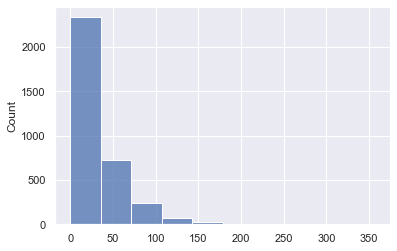

In [14]:
sns.histplot(data=expon.rvs(loc=0, scale=cars.fuel_cons.
                            describe()['mean'],
                            size=int(cars.fuel_cons.describe()['count'])), bins=10, color='b');

По гистограмме видно, что теоретическое распределение сильно отличается от фактического, поэтому нулевую гипотезу отвергаем без статистической проверки.

Проверим, какие модели имеются в наличии.

count               3407
unique                20
top       Nissan Qashqai
freq                1958
Name: model, dtype: object

Nissan Qashqai           57.47
VW Polo                  11.51
smart fortwo              6.08
Kia Rio                   5.52
Hyundai Creta             2.94
Kia Rio X-line            2.11
smart forfour             2.03
Hyundai Solaris           1.76
MINI Cooper               1.67
Electric scooter lite     1.41
Kia Soul                  1.38
fortwo turbo              1.35
forfour turbo             1.09
BMW Active Tourer         1.06
Mercedes A-class          0.79
Nissan X-Trail            0.79
Kia Picanto               0.68
Renault Kaptur            0.23
Renault Arkana            0.12
forfour soft-top          0.03
Name: model, dtype: float64

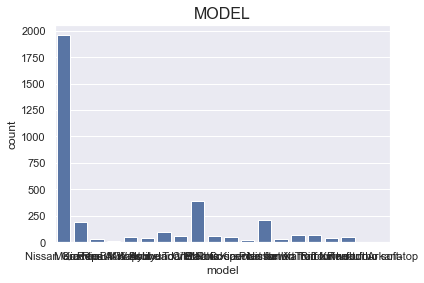

In [15]:
eda(cars, 'model')

Визуализируем автомобили на карте

In [16]:
import folium

In [17]:
m = folium.Map(location=[55.75, 37.616667], zoom_start=4)
for i in range(0, len(cars)):
    color='green'
    folium.Marker(location=[cars.iloc[i, 0], cars.iloc[i, 1]]).add_to(m)
display(m)

Выгрузим данные с сайта с определённым интервалом, чтобы посмотреть, как меняется количество машин с течением времени. Создадим базу данных для сохранения результатов. Будем выгружать данные каждые пять минут в течение 10 часов.

In [18]:
import sqlite3
import time
import datetime

In [19]:
conn = sqlite3.connect('YouDrive.db')
c = conn.cursor()
c.executescript(
    
"""
CREATE TABLE IF NOT EXISTS cars (
    latitude REAL,
    longitude REAL,
    color TEXT,
    model TEXT,
    fuel REAL,
    time TEXT DEFAULT CURRENT_TIMESTAMP
    )
"""
                )

conn.commit()
conn.close()

In [20]:
counter = 0
for i in range(0,1):
    cars = pd.DataFrame(requests.get('http://youdrive.today/info').json()['cars'])
    cars = cars[['latitude', 'longitude', 'color', 'model', 'fuel']]
    conn = sqlite3.connect('YouDrive.db')
    cars.to_sql('cars', conn, if_exists='append', index=False)
    conn.close()
    counter += 1
    print('{} Данные выгружены в {}'.format(counter, datetime.datetime.now()))
    time.sleep(300)

1 Данные выгружены в 2020-10-18 10:11:30.710842


Посмотрим, как менялось количество автомобилей в течение времени.

In [56]:
conn = sqlite3.connect('YouDrive.db')
cars_t = pd.read_sql(
    """
    SELECT time(time) as time, count(*) as cars_total
    FROM cars
    GROUP BY time
    """, conn)
conn.close()
cars_t.time = pd.to_datetime(cars_t.time).round("min")
display(cars_t.info())
display(cars_t.cars_total.describe())
display(cars_t.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        46 non-null     datetime64[ns]
 1   cars_total  46 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 864.0 bytes


None

count      46.000000
mean     3053.456522
std       485.595474
min         1.000000
25%      2985.750000
50%      3099.000000
75%      3255.500000
max      3402.000000
Name: cars_total, dtype: float64

,time,cars_total
0,2020-10-18 18:01:00,2931
1,2020-10-18 18:06:00,2941
2,2020-10-18 18:11:00,2950
3,2020-10-18 18:16:00,2967
4,2020-10-18 18:21:00,2983


В данных имеем один выброс, удалим его.

In [57]:
cars_t = cars_t[cars_t.cars_total > 2000]

In [58]:
cars_t

,time,cars_total
0,2020-10-18 18:01:00,2931
1,2020-10-18 18:06:00,2941
2,2020-10-18 18:11:00,2950
3,2020-10-18 18:16:00,2967
4,2020-10-18 18:21:00,2983
5,2020-10-18 18:26:00,2975
6,2020-10-18 18:31:00,2985
7,2020-10-18 18:36:00,2800
8,2020-10-18 18:41:00,3033
9,2020-10-18 18:46:00,3038


Построим график, как менялось количество автомобилей c 6 до 22 часов.

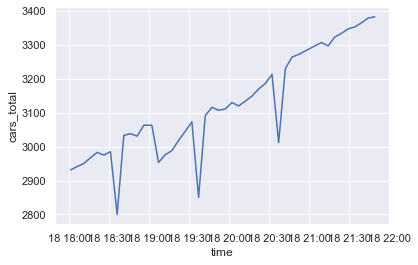

In [67]:
sns.lineplot(x="time", y="cars_total",
             data=cars_t[(cars_t.time > pd.to_datetime('2020-10-18 18:00:00'))&
                        (cars_t.time < pd.to_datetime('2020-10-18 22:00:00'))]
            ).set_xticklabels(cars_t.time, minor=True);

Видим тренд на увеличение автомобилей. Предположительно на сайте публикуется информация о доступных автомобилях, которая далее используется в мобильном приложении. 

## area

In [73]:
area = pd.DataFrame(raw_data['area'])
display(area.info())
display(area.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Columns: 287 entries, 0 to 286
dtypes: object(287)
memory usage: 179.5+ KB


None

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,"{'longitude': 37.84172564285271, 'latitude': 5...","{'longitude': 37.83644199371337, 'latitude': 5...","{'longitude': 37.83888816833496, 'latitude': 5...","{'longitude': 37.838716506958015, 'latitude': ...","{'longitude': 37.838501930236816, 'latitude': ...","{'longitude': 37.836120128631585, 'latitude': ...","{'longitude': 37.83549785614014, 'latitude': 5...","{'longitude': 37.834510803222656, 'latitude': ...","{'longitude': 37.83279418945313, 'latitude': 5...","{'longitude': 37.827901840209954, 'latitude': ...",...,None,None,None,None,None,None,None,None,None,None
1,"{'longitude': 37.37309, 'latitude': 55.81306}","{'longitude': 37.37600326538086, 'latitude': 5...","{'longitude': 37.38050937652587, 'latitude': 5...","{'longitude': 37.37516641616821, 'latitude': 5...","{'longitude': 37.368146, 'latitude': 55.827895}","{'longitude': 37.364906, 'latitude': 55.825663}","{'longitude': 37.36250638961792, 'latitude': 5...","{'longitude': 37.361154556274414, 'latitude': ...","{'longitude': 37.359679, 'latitude': 55.818908}","{'longitude': 37.35608677387442, 'latitude': 5...",...,None,None,None,None,None,None,None,None,None,None
2,"{'longitude': 37.398804099331336, 'latitude': ...","{'longitude': 37.389582828818384, 'latitude': ...","{'longitude': 37.383435315143075, 'latitude': ...","{'longitude': 37.37531181492928, 'latitude': 5...","{'longitude': 37.380361558305424, 'latitude': ...","{'longitude': 37.38080066642509, 'latitude': 5...","{'longitude': 37.380361558305424, 'latitude': ...","{'longitude': 37.38080066642509, 'latitude': 5...","{'longitude': 37.382337544843914, 'latitude': ...","{'longitude': 37.37926378800626, 'latitude': 5...",...,None,None,None,None,None,None,None,None,None,None
3,"{'longitude': 37.46814250946044, 'latitude': 5...","{'longitude': 37.46830779046474, 'latitude': 5...","{'longitude': 37.46893230637963, 'latitude': 5...","{'longitude': 37.46962308883666, 'latitude': 5...","{'longitude': 37.47292757034302, 'latitude': 5...","{'longitude': 37.47432231903076, 'latitude': 5...","{'longitude': 37.47518062591553, 'latitude': 5...","{'longitude': 37.47908592224121, 'latitude': 5...","{'longitude': 37.482283115386956, 'latitude': ...","{'longitude': 37.48603820800781, 'latitude': 5...",...,None,None,None,None,None,None,None,None,None,None
4,"{'longitude': 37.27372188960383, 'latitude': 5...","{'longitude': 37.27729756955445, 'latitude': 5...","{'longitude': 37.27787429212714, 'latitude': 5...","{'longitude': 37.28491030751384, 'latitude': 5...","{'longitude': 37.29021615518251, 'latitude': 5...","{'longitude': 37.29586803639479, 'latitude': 5...","{'longitude': 37.298463287971856, 'latitude': ...","{'longitude': 37.30371146338326, 'latitude': 5...","{'longitude': 37.307687401771545, 'latitude': ...","{'longitude': 37.30925917625427, 'latitude': 5...",...,None,None,None,None,None,None,None,None,None,None


In [72]:
area.iloc[0,0]

{'longitude': 37.84172564285271, 'latitude': 55.780004324022656}

## areas

In [76]:
raw_data['areas']

{'MKAD': [{'longitude': 37.84172564285271, 'latitude': 55.780004324022656},
  {'longitude': 37.83644199371337, 'latitude': 55.8088482647473},
  {'longitude': 37.83888816833496, 'latitude': 55.80891458512053},
  {'longitude': 37.838716506958015, 'latitude': 55.81042183586404},
  {'longitude': 37.838501930236816, 'latitude': 55.812290745729555},
  {'longitude': 37.836120128631585, 'latitude': 55.81224251692558},
  {'longitude': 37.83549785614014, 'latitude': 55.81794515869895},
  {'longitude': 37.834510803222656, 'latitude': 55.82129642718674},
  {'longitude': 37.83279418945313, 'latitude': 55.823996519869155},
  {'longitude': 37.827901840209954, 'latitude': 55.82790167952735},
  {'longitude': 37.824554443359375, 'latitude': 55.829444350621046},
  {'longitude': 37.80369758605958, 'latitude': 55.84192809327008},
  {'longitude': 37.75525267724611, 'latitude': 55.86703807949491},
  {'longitude': 37.7199315476074, 'latitude': 55.884581598066774},
  {'longitude': 37.70979881286621, 'latitude'

## area_groups

In [77]:
raw_data['area_groups']

{'moscow': ['MKAD',
  'P_Poima',
  'Himki',
  'Kommunarka',
  'Odintsovo_main',
  'Moskovsky',
  'Trehgorka',
  'BMW_BD',
  'Mega_BD1',
  'Mega_BD2',
  'Mitino_main',
  'Pyhtino_SP',
  'Rasskazovka_subw',
  'Novoperedelkino',
  'OBI_Lenta_47km',
  'Solntsevo',
  'Odintsovo_9mkr',
  'Odintsovo_soyuz',
  'Novomoskovsky_TK',
  'Odintsovo_Sosnovaya',
  'Altufievo_CC'],
 'saint_petersburg': ['KAD',
  'Rybackoe',
  'Devyatkino',
  'Murino',
  'Shushary',
  'Pulkovo3_Lenta',
  'Yanino',
  'MegaParnas',
  'Lenta-Krauta',
  'Yanino_2nd',
  'VO_Namyv',
  'Жилой комплекс "Чистое небо"',
  'Кронштадт (Обводный канал)',
  'Кронштадт (Остров Котлин)',
  'Кронштадт (улица Станюковича)',
  'МО "г. Ломоносов"',
  'Петродворцовый (МО "г. Петергоф")',
  'Петродворцовый (Санкт-Петербургский проспект)',
  'Горелово (магазины)',
  'Горелово (жилой комплекс)',
  'Курортный (Гагаринская улица)',
  'Курортный (улица Токарева)',
  'Курортный (Дубковское шоссе)',
  'Курортный (Волгоградская улица)'],
 'sochi': [

## layers

In [79]:
raw_data['layers']

[{'pin_img': '',
  'title': 'Special parking spaces',
  'points': [{'lat': 55.722799,
    'lon': 37.652316,
    'pin_img': 'https://youdrive.today/static/resources/parking_pointer/pin_big_parking',
    'title': 'Novospassky',
    'description': 'YouDrive parking lots are in the heart of Business Quarter next to fontain.'},
   {'lat': 55.7806206,
    'lon': 37.5694768,
    'pin_img': 'https://youdrive.today/static/resources/parking_pointer/pin_big_parking',
    'title': 'Bolshevik',
    'description': 'You can leave YouDrive car in front of Business Center main entrance.  '},
   {'lat': 55.74391,
    'lon': 37.554251,
    'pin_img': 'https://youdrive.today/static/resources/parking_pointer/pin_big_parking',
    'title': 'Dorogomilovsky market',
    'description': 'You can leave YouDrive car in the market parking right at the entrance from Platonovskaya street '},
   {'lat': 43.447262,
    'lon': 39.937734,
    'pin_img': 'https://youdrive.today/static/resources/parking_pointer/pin_big_pa

## success

In [80]:
raw_data['success']

True

# Выводы

С сайта загружены данные, проанализированы машины по модели. YuoDrive работает в нескольких городах. Несложно связать геометки с городом и посмотреть машины каких марок используются в каждом городе.

Проанализировны данные о машинах, опубликованных на сайте в динамике, ближе к вечеру количество свободных машин возрастает.

Построено распределение машин по уровню топлива. Установлено, что уровень топлива зависит от трёх случайных величин, при этом нам известен закон распределения только одной величины. Для определения закона распределения двух других случайных величин недостаточно данных. Средний запас топлива по всему парку в течение времени по центральной предельной теореме должен быть распределён нормально.

В целом по имеющимся данным конкуренты могут собрать следующую информацию: количество доступных машин, зона обслуживание, характеристики машин, возможно, по имеющимся данным можно определить маршруты постоянных клиентов, либо области, где клиенты YouDrive берут машины в аренду наиболее часто. Обеспечив в этим местах постоянное наличие машин от конкурирующего каршеринга, возможно, конкурирующий каршеринг смог бы переманить часть клиентов.

Возможно также построить модель, которая позволит предсказывать общее количество машин в парке, в таком случае можно будет посчитать коэффициент загрузки парка. Пердположительно, финансовая модел